In [ ]:
# --- Colab: upload your compare_results.csv ---
from google.colab import files
uploaded = files.upload()

import io, pandas as pd, numpy as np, matplotlib.pyplot as plt
from IPython.display import display

# ---------- Load ----------
fn = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[fn]))

Saving compare_results.csv to compare_results.csv


In [ ]:
# ---------- Sanity checks ----------
# We need totals or computable parts for profiler energy, and plug + CO2 cols, plus variant.
required_any = [
    ('prof_total_mWh', ['prof_pkg_mWh','prof_igpu_mWh','prof_dram_mWh']),
    ('plug_net_mWh', []),
    ('prof_co2_mg', []),
    ('plug_net_co2_mg', []),
    ('variant', [])
]

missing_hard = []
for col, alts in required_any:
    if col not in df.columns:
        if not alts or not set(alts).issubset(df.columns):
            missing_hard.append(col)

if missing_hard:
    raise ValueError(
        "Missing required column(s) or computable parts: "
        f"{missing_hard}. CSV must include columns like: "
        "prof_total_mWh (or prof_pkg_mWh + prof_igpu_mWh + prof_dram_mWh), "
        "plug_net_mWh, prof_co2_mg, plug_net_co2_mg, variant."
    )

# If total not present, compute from parts (fill NaN with 0 for parts)
if 'prof_total_mWh' not in df.columns:
    df['prof_total_mWh'] = (
        df['prof_pkg_mWh'].astype(float).fillna(0)
        + df['prof_igpu_mWh'].astype(float).fillna(0)
        + df['prof_dram_mWh'].astype(float).fillna(0)
    )

# Normalize variant label (keep original for display)
df['variant_norm'] = df['variant'].astype(str).str.strip()

# ---------- Per-variant means ----------
agg_cols = ['prof_total_mWh','plug_net_mWh','prof_co2_mg','plug_net_co2_mg']
g = df.groupby('variant_norm', as_index=True)[agg_cols].mean()


In [ ]:
# ---------- Find baseline (case-insensitive) ----------
idx_lower = g.index.str.lower()
if not (idx_lower == 'baseline').any():
    raise ValueError("Baseline row not found. Ensure at least one variant is named 'baseline' (any case).")
bl = g.loc[g.index[(idx_lower == 'baseline')][0]]  # baseline row (Series)

# ---------- Improvement function (positive % = lower than baseline = better) ----------
def improvement_vs_base(series: pd.Series, base_value: float) -> pd.Series:
    if pd.isna(base_value) or base_value == 0:
        # can't compute; return NaNs
        return pd.Series(np.nan, index=series.index)
    return (1.0 - (series.astype(float) / float(base_value))) * 100.0


In [ ]:
# ---------- Compute improvements ----------
g['prof_energy_improve_%'] = improvement_vs_base(g['prof_total_mWh'], bl['prof_total_mWh'])
g['plug_energy_improve_%'] = improvement_vs_base(g['plug_net_mWh'],  bl['plug_net_mWh'])
g['prof_co2_improve_%']    = improvement_vs_base(g['prof_co2_mg'],    bl['prof_co2_mg'])
g['plug_co2_improve_%']    = improvement_vs_base(g['plug_net_co2_mg'],bl['plug_net_co2_mg'])


In [ ]:
# ---------- Build rounded presentation tables ----------
g_round = g.copy()
for c in ['prof_total_mWh','plug_net_mWh','prof_co2_mg','plug_net_co2_mg']:
    g_round[c] = g_round[c].round(2)
for c in ['prof_energy_improve_%','plug_energy_improve_%','prof_co2_improve_%','plug_co2_improve_%']:
    g_round[c] = g_round[c].round(1)

g_round.index.name = 'variant'
g_round = g_round.reset_index()

In [ ]:
# Energy summary table (Profiler + Plug)
energy_table = g_round[['variant','prof_total_mWh','prof_energy_improve_%',
                        'plug_net_mWh','plug_energy_improve_%']].copy()
energy_table.columns = [
    'variant',
    'profiler_energy_mean (mWh)','profiler_energy_improve (%)',
    'plug_net_energy_mean (mWh)','plug_energy_improve (%)'
]


In [ ]:
# Show tables in notebook
print("Energy summary (means and improvement vs baseline):")
display(energy_table.sort_values('profiler_energy_mean (mWh)', ascending=False).reset_index(drop=True))

Energy summary (means and improvement vs baseline):


,variant,profiler_energy_mean (mWh),profiler_energy_improve (%),plug_net_energy_mean (mWh),plug_energy_improve (%)
0,baseline,1557.67,0.0,1018.36,0.0
1,ll,1538.67,1.2,901.56,11.5
2,cm,1499.33,3.7,999.93,1.8
3,ll_cm,1134.00,27.2,127.88,87.4
4,ic,1019.67,34.5,535.13,47.5
5,ll_cm_ic,787.33,49.5,657.45,35.4
6,ic_cm,774.33,50.3,104.01,89.8
7,ll_ic,769.33,50.6,627.59,38.4


In [ ]:
# CO2 summary table (Profiler + Plug)
co2_table = g_round[['variant','prof_co2_mg','prof_co2_improve_%',
                     'plug_net_co2_mg','plug_co2_improve_%']].copy()
co2_table.columns = [
    'variant',
    'profiler_co2_mean (mg)','prof_co2_improve (%)',
    'plug_net_co2_mean (mg)','plug_co2_improve (%)'
]

In [ ]:
print("CO₂ summary (means and improvement vs baseline):")
display(co2_table.sort_values('profiler_co2_mean (mg)', ascending=False).reset_index(drop=True))

CO₂ summary (means and improvement vs baseline):


,variant,profiler_co2_mean (mg),prof_co2_improve_%,plug_net_co2_mean (mg),plug_co2_improve_%
0,baseline,687.00,0.0,442.70,0.0
1,ll,680.33,1.0,398.47,10.0
2,cm,663.00,3.5,442.00,0.2
3,ll_cm,501.27,27.0,56.53,87.2
4,ic,461.00,32.9,236.53,46.6
5,ic_cm,369.07,46.3,46.00,89.6
6,ll_cm_ic,346.70,49.5,290.60,34.4
7,ll_ic,273.80,60.1,277.37,37.3


In [ ]:
# Save tables
energy_table.to_csv('summary_energy_by_variant.csv', index=False)
co2_table.to_csv('summary_co2_by_variant.csv', index=False)

In [ ]:
# ---------- Plot helpers ----------
def bar_sorted(series: pd.Series, title: str, ylabel: str, out_png: str):
    """Bar chart sorted descending by value. Annotate bars, remove black line."""
    series = series.dropna()
    order = series.sort_values(ascending=False)
    plt.figure(figsize=(12, 7))
    bars = plt.bar(range(len(order)), order.values)
    plt.xticks(range(len(order)), order.index, rotation=35, ha='right')
    plt.ylabel(ylabel)
    plt.title(title)
    # annotate values
    for i, v in enumerate(order.values):
        plt.text(i, v + (0.02 * (order.max() if order.max() != 0 else 1)), f"{v:.1f}", ha='center', va='bottom')
    # remove top/right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.show()

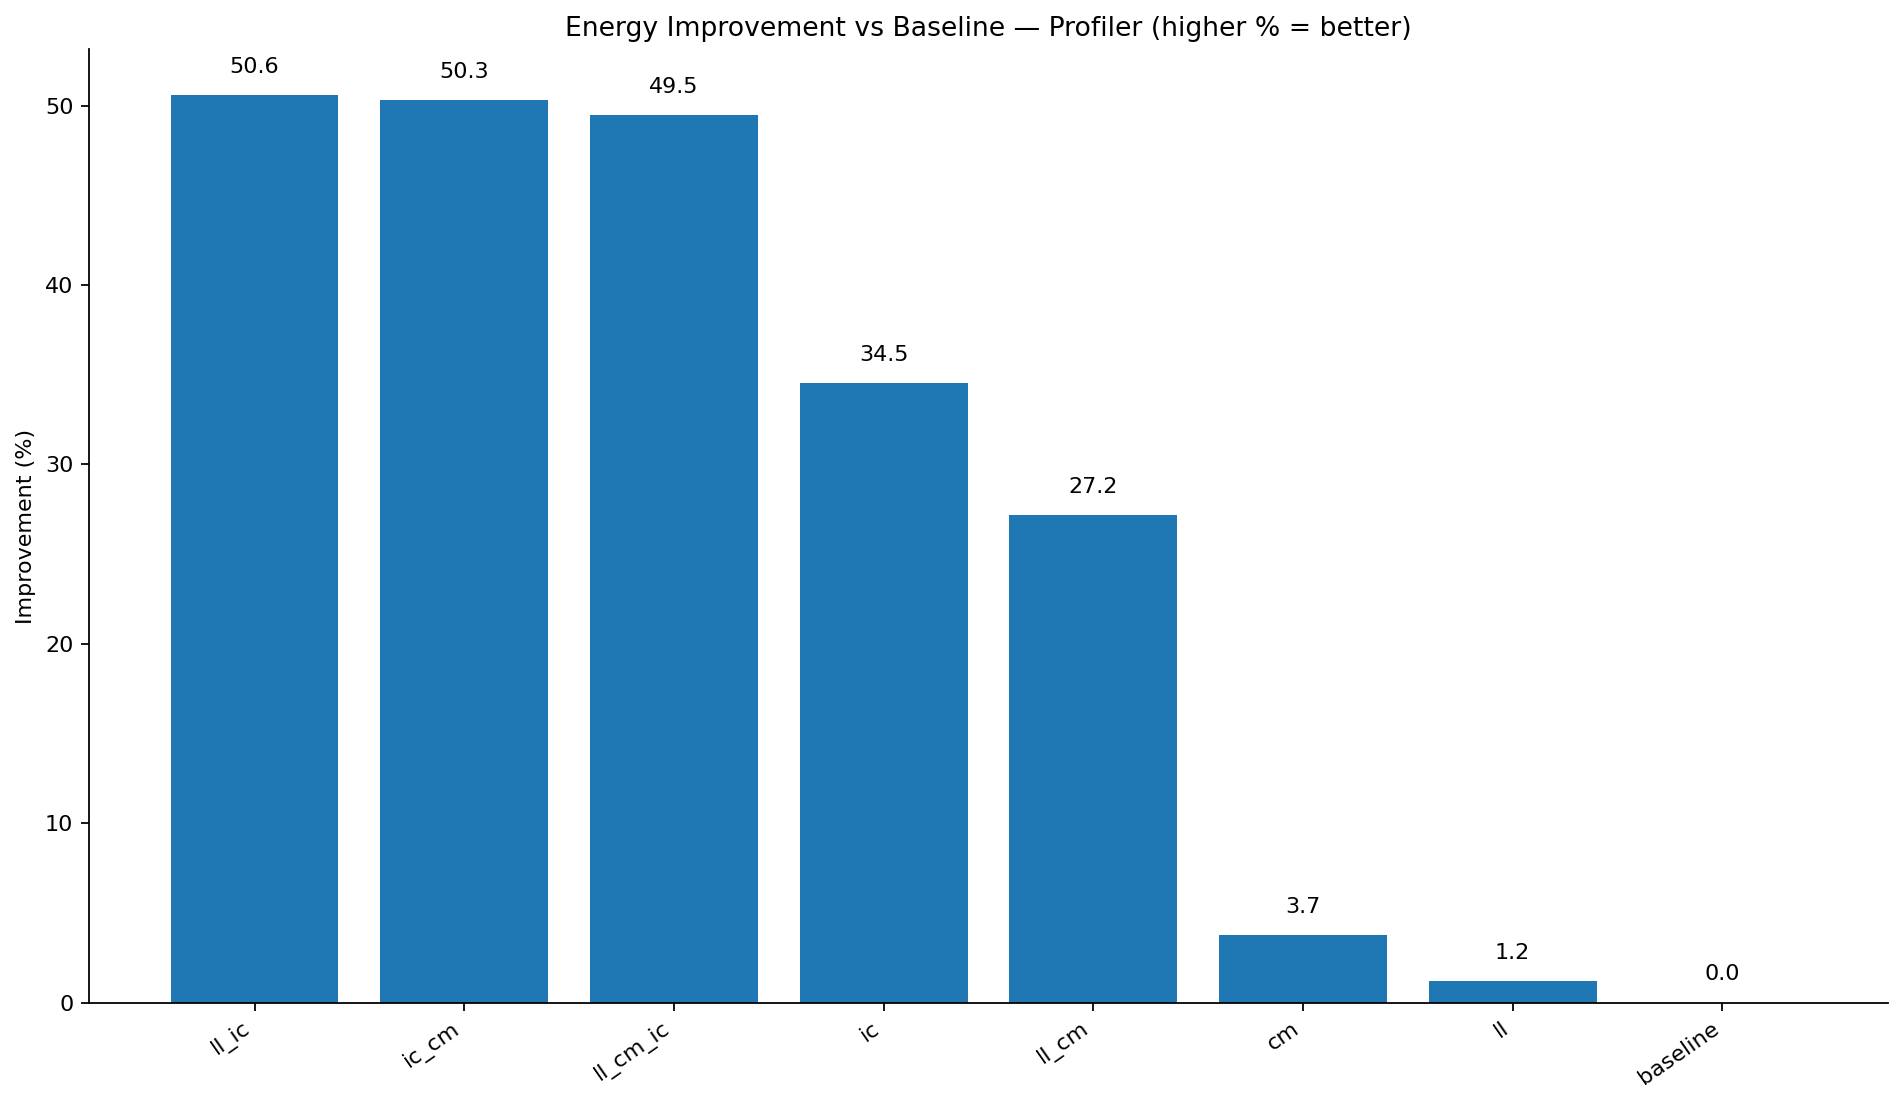

In [ ]:
# 1) Energy improvement (Profiler) — descending
bar_sorted(
    g['prof_energy_improve_%'],
    title='Energy Improvement vs Baseline — Profiler (higher % = better)',
    ylabel='Improvement (%)',
    out_png='plot_prof_energy_improvement_sorted.png'
)


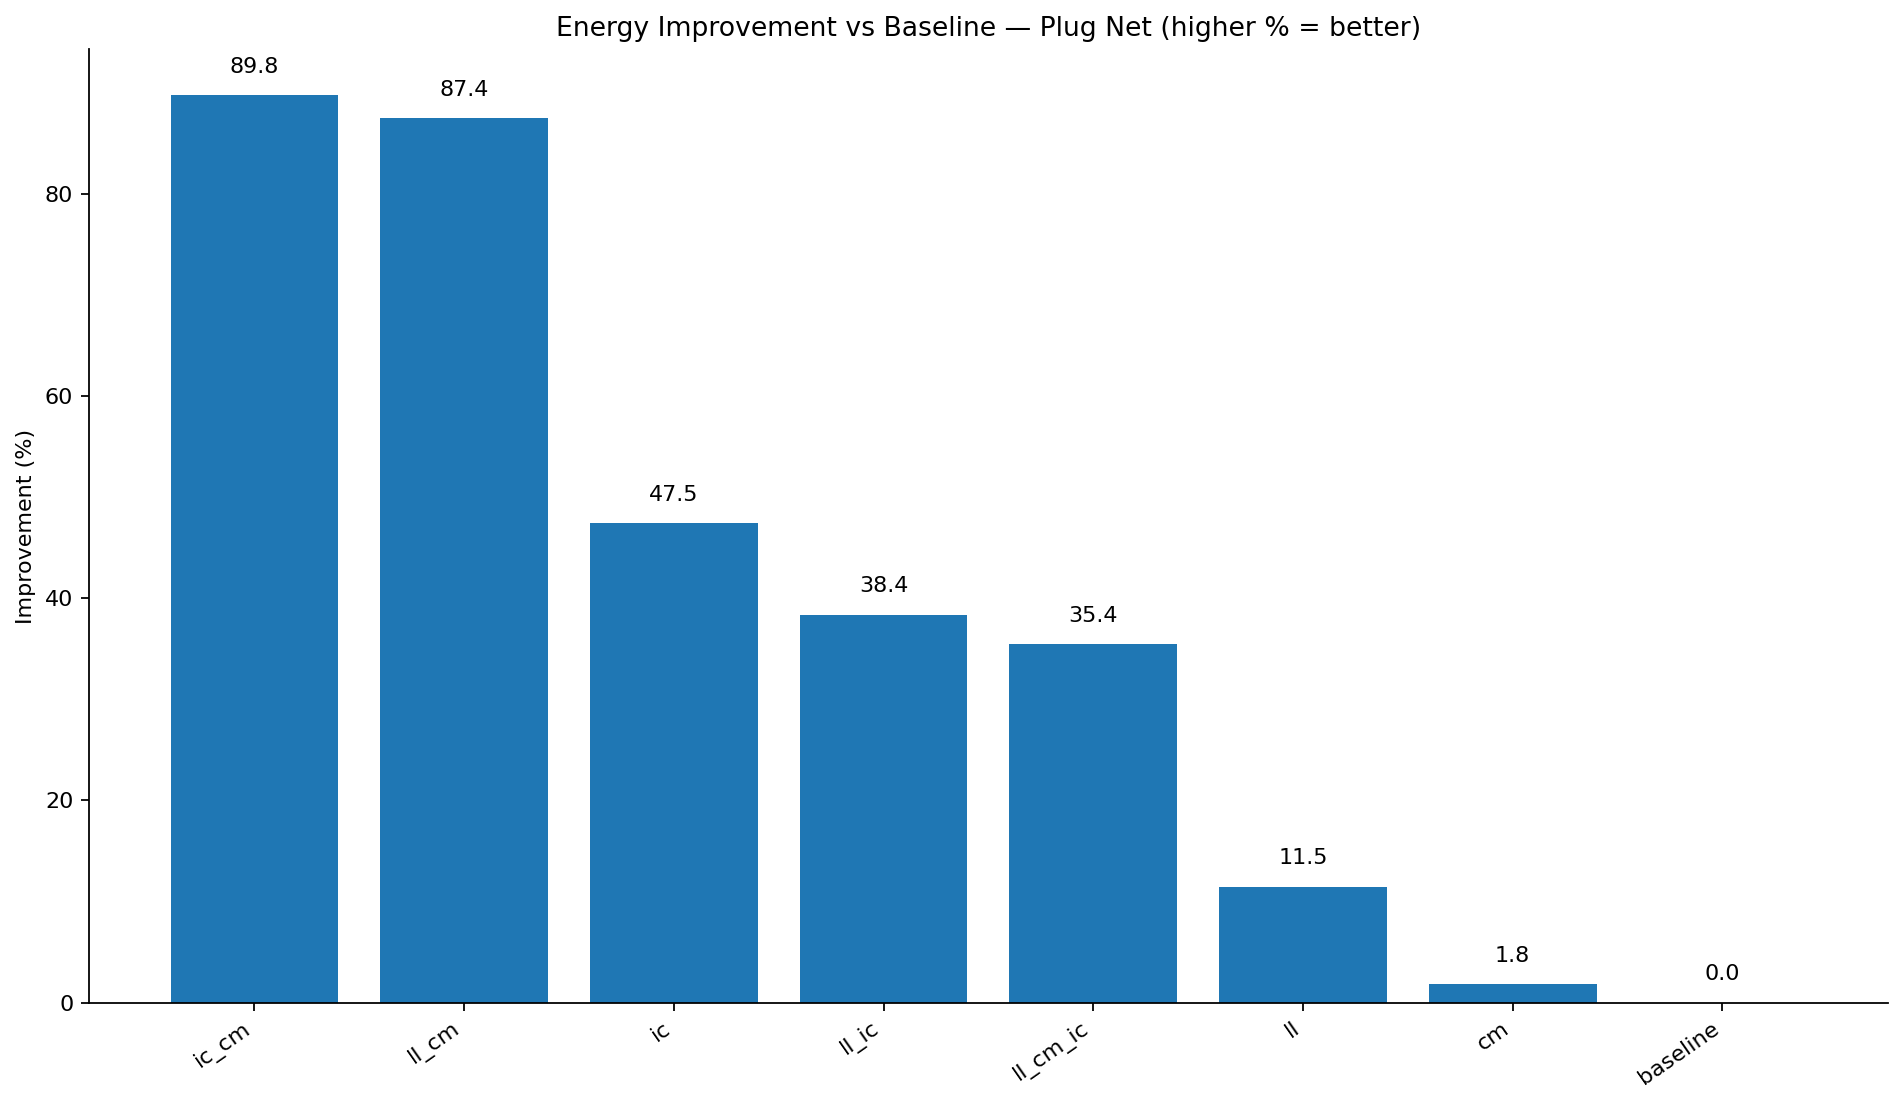

In [ ]:
# 2) Energy improvement (Plug) — descending
bar_sorted(
    g['plug_energy_improve_%'],
    title='Energy Improvement vs Baseline — Plug Net (higher % = better)',
    ylabel='Improvement (%)',
    out_png='plot_plug_energy_improvement_sorted.png'
)

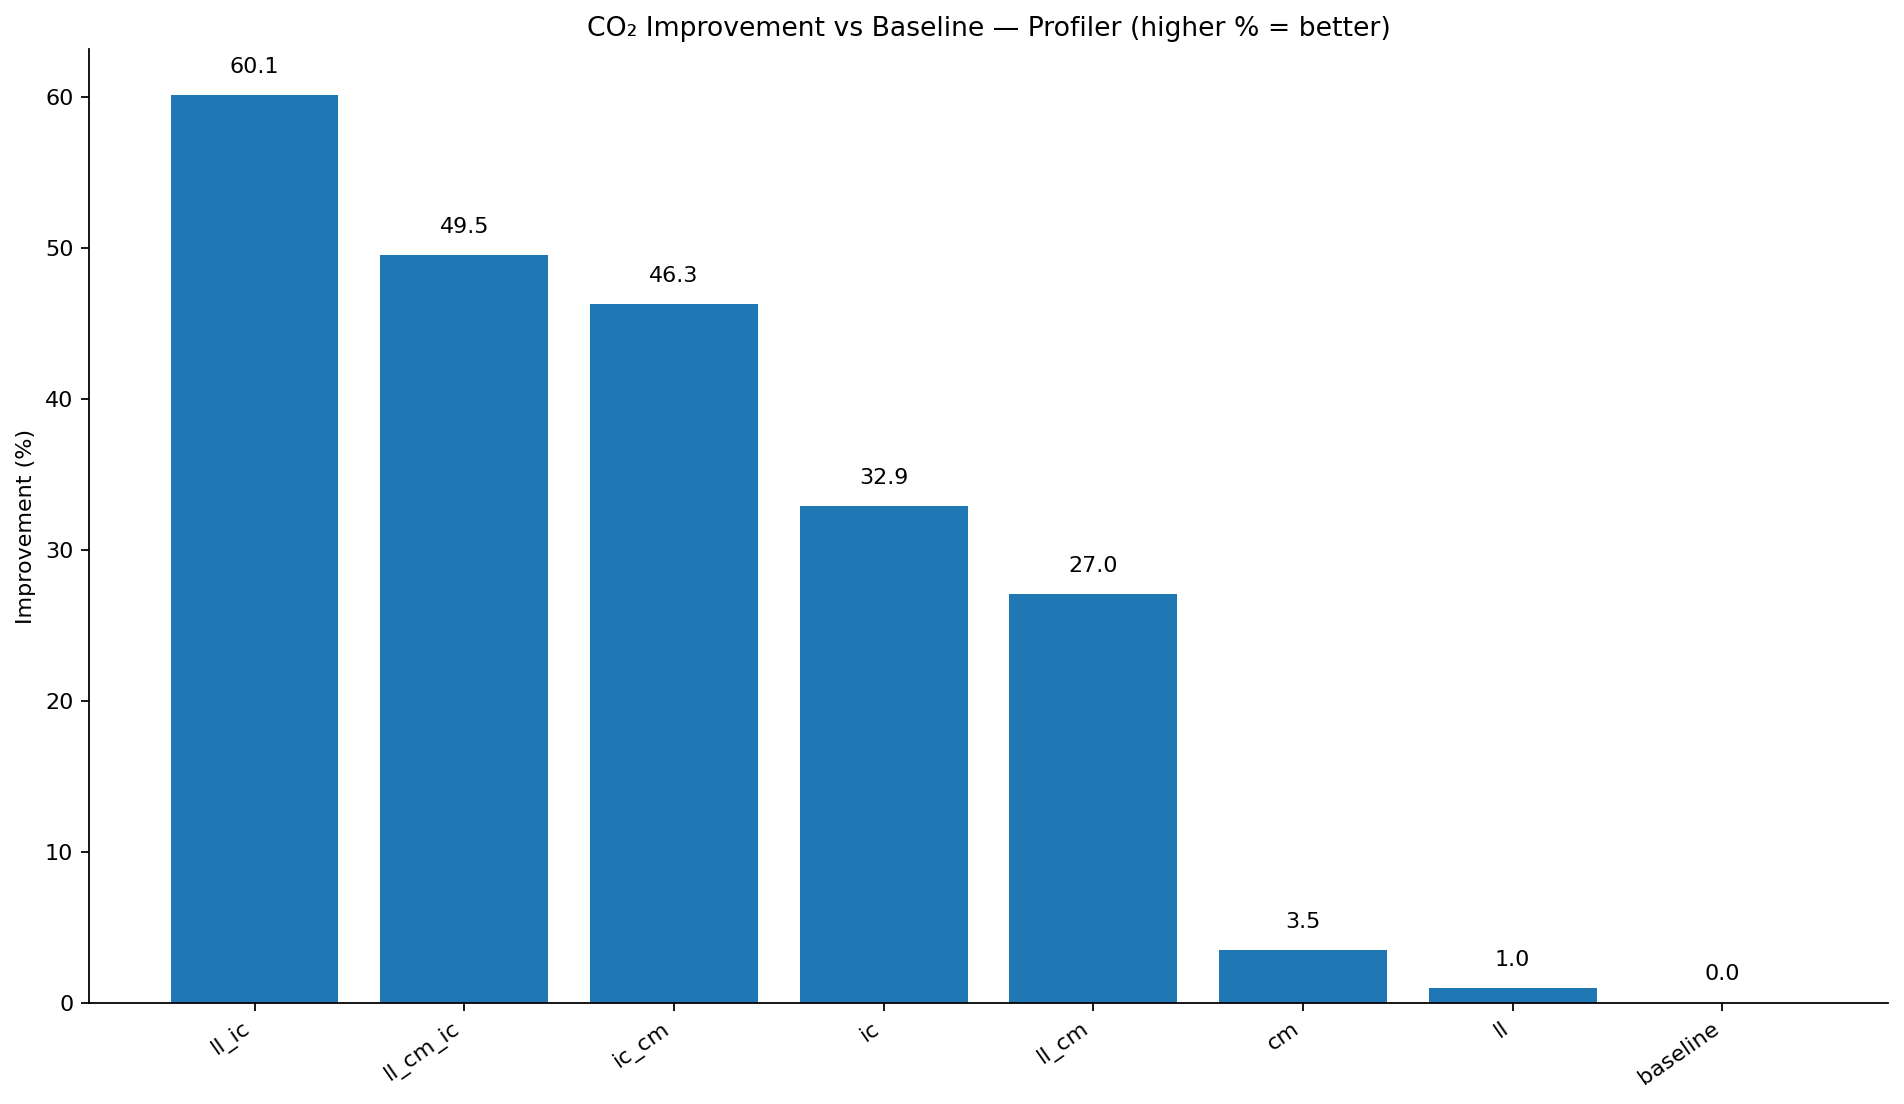

In [ ]:
# 3) CO₂ improvement (Profiler) — descending
bar_sorted(
    g['prof_co2_improve_%'],
    title='CO₂ Improvement vs Baseline — Profiler (higher % = better)',
    ylabel='Improvement (%)',
    out_png='plot_prof_co2_improvement_sorted.png'
)

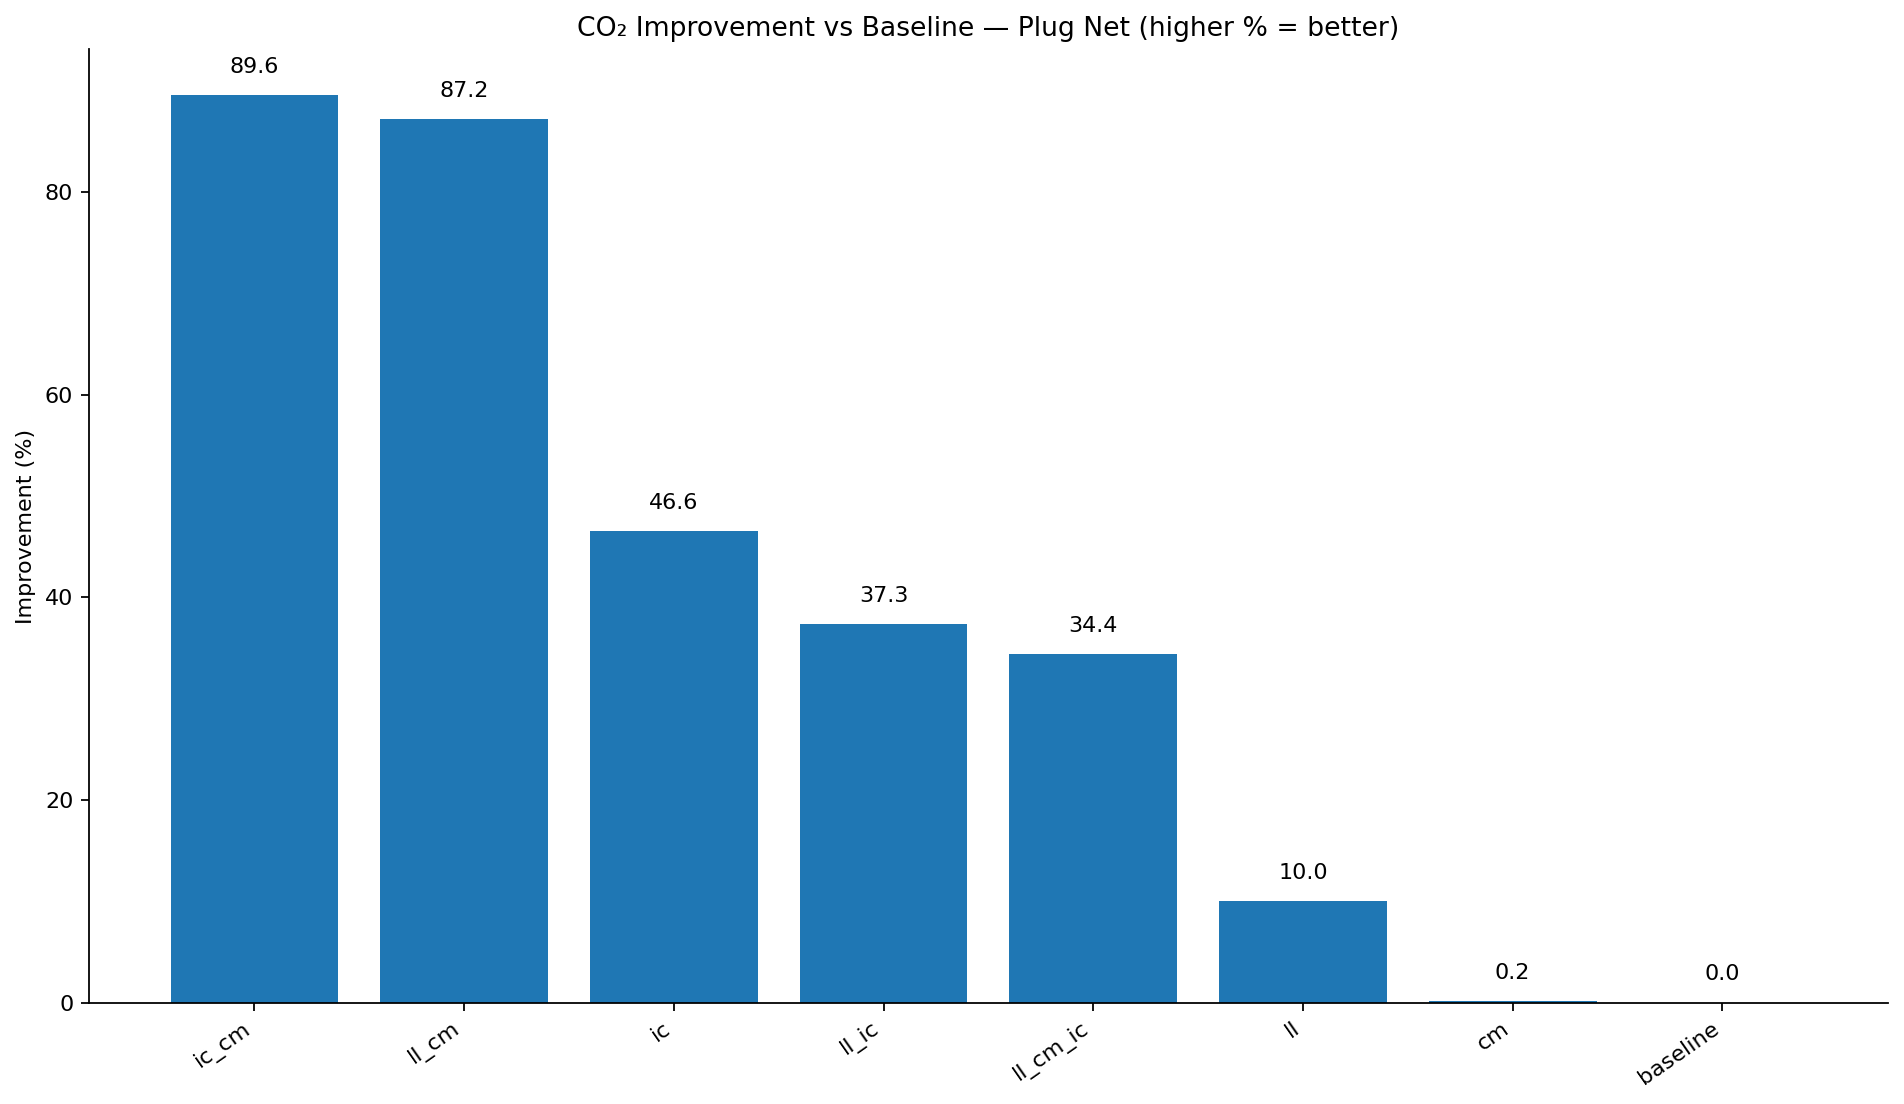

In [ ]:
# 4) CO₂ improvement (Plug) — descending
bar_sorted(
    g['plug_co2_improve_%'],
    title='CO₂ Improvement vs Baseline — Plug Net (higher % = better)',
    ylabel='Improvement (%)',
    out_png='plot_plug_co2_improvement_sorted.png'
)
